# Setting things up

In [1]:
from general import *
from exp1 import *
import time
import pandas as pd
import multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

random_state=42
np.random.seed(random_state)
cpu=mp.cpu_count() 
cpu

8

In [3]:
####
alpha=.1 #Significance level
iterations=48 #MC simulations to calculate type-1 error and power
ps=[40] #Z dim
skew=0
us=[0,50,100,200,300,500] #Training set size
n=200 #Test set size
m=800
B=100 #Number of permutations/samplings (RESIT,CRT,CPT)
npar = 7 #Number of different values for parameters like gamma, theta, c etc.
nbas = 10 #Number of different generative configurations (different pairs (a,b))

####
skews = [0]
losses = ['mse']

# Experiments

In [4]:
def exp3(it, theta, gamma, c, a, b, skew, m, n, u, p, loss, alpha, B, 
         tests={'stfr':True, 'resit':True, 'gcm':True, 'crt':True, 'cpt':True,'rbpt':True, 'rbpt2':True}):
    
    #Gen. training data
    Z_train=sample_z(m, p, random_state=6*it)
    X_train=sample_x(Z_train, b, random_state=6*it+1)
    Y_train=sample_y(X_train, Z_train, a, b, c, gamma, skew, random_state=6*it+2)

    #Gen. unlab data
    if u>0:
        Z_unlab=sample_z(u, p, random_state=97532*it) #np.vstack((Z_train, ))
        X_unlab=sample_x(Z_unlab, b, random_state=97532*it+1) #np.hstack((X_train, ))
        Z_unlab=np.vstack((Z_train, Z_unlab))
        X_unlab=np.vstack((X_train, X_unlab))
    else:
        Z_unlab=Z_train
        X_unlab=X_train
        
    #Gen. test data
    Z_test=sample_z(n, p, random_state=6*it+3)
    X_test=sample_x(Z_test, b, random_state=6*it+4)
    Y_test=sample_y(X_test, Z_test, a, b, c, gamma, skew, random_state=6*it+5)  
            
    #Fitting models
    g1 = g()
    g1.fit(X_train, Z_train, Y_train)
    g2 = g()
    g2.fit(None, Z_train, Y_train)
    g3 = g()
    g3.fit(None, Z_train, X_train)
                
    #STFR
    if tests['stfr']: 
        start_time = time.time()
        reject_stfr = (get_pval_stfr(X_test, Z_test, Y_test, g1, g2, loss=loss) <= alpha)
        time_stfr = time.time() - start_time
    else: 
        reject_stfr = np.nan
        time_stfr = np.nan
    
        
    #RESIT
    if tests['resit']: 
        start_time = time.time()
        reject_resit = (get_pval_resit(X_test, Z_test, Y_test, g2, g3, B=B) <= alpha)
        time_resit = time.time() - start_time
    else: 
        reject_resit = np.nan
        time_resit = np.nan
    
    
    #GCM
    if tests['gcm']: 
        start_time = time.time()
        reject_gcm = (get_pval_gcm(X_test, Z_test, Y_test, g2, g3) <= alpha)
        time_gcm = time.time() - start_time
    else: 
        reject_gcm = np.nan
        time_gcm = np.nan
    
    
    #CRT
    if tests['crt']: 
        start_time = time.time()
        reject_crt = (get_pval_crt(X_test, Z_test, Y_test, b, g1, g2, theta, B, loss=loss) <= alpha)
        time_crt = time.time() - start_time
    else: 
        reject_crt = np.nan   
        time_crt = np.nan   
    
    
    #CPT
    if tests['cpt']: 
        start_time = time.time()
        reject_cpt = (get_pval_cpt(X_test, Z_test, Y_test, b, g1, g2, theta, B, loss=loss) <= alpha)
        time_cpt = time.time() - start_time
    else: 
        reject_cpt = np.nan
        time_cpt = np.nan
    
    
    #RBPT
    if tests['rbpt']: 
        start_time = time.time()
        reject_rbpt = (get_pval_rbpt(X_test, Z_test, Y_test, b, g1, theta, loss=loss) <= alpha)
        time_rbpt = time.time() - start_time
    else: 
        reject_rbpt = np.nan
        time_rbpt = np.nan
    
    
    #RBPT2
    if tests['rbpt2']: 
        start_time = time.time()
        k=10
        h = GridSearchCV(KernelRidge(kernel='poly'), cv=2, n_jobs=1, scoring='neg_mean_squared_error',
                         param_grid={"alpha": np.logspace(0,-k,k), "degree": [2]}) 
        
        h.fit(Z_unlab, g1.predict(X_unlab, Z_unlab).squeeze())
        
        reject_rbpt2 = (get_pval_rbpt2(X_test, Z_test, Y_test, g1, h, loss=loss) <= alpha)
        time_rbpt2 = time.time() - start_time
    else: 
        reject_rbpt2 = np.nan
        time_rbpt2 = np.nan
    
    
    #Output
    return [reject_stfr, reject_resit, reject_gcm, reject_crt, reject_cpt, reject_rbpt, reject_rbpt2,
            time_stfr, time_resit, time_gcm, time_crt, time_cpt, time_rbpt, time_rbpt2] 

In [5]:
results = {'set':[], 'p':[],
           'ba':[], 'c':[], 'theta':[], 'skew':[], 'u':[], 'gamma':[], 'loss':[],
           'stfr':[], 'resit':[], 'gcm':[], 'crt':[], 'cpt':[],'rbpt':[], 'rbpt2':[],
           'stfr_time':[], 'resit_time':[], 'gcm_time':[], 'crt_time':[], 'cpt_time':[], 'rbpt_time':[], 'rbpt2_time':[]}

count=0

for p in ps:
    
    bas = [[np.random.normal(0, 1, p).reshape(p,1), np.random.normal(0, 1, p).reshape(p,1)] for j in range(nbas)]
    
    for ba in bas:
        # Parameters a and b
        b = ba[0]
        a = ba[1]

        for u in tqdm(us):
            for loss in losses:

                #### Type I error ####
                c = 0

                #STFR,RESIT,GCM,RBPT,RBPT2#
                tests={'stfr':False, 'resit':False, 'gcm':False, 'crt':False, 'cpt':False, 'rbpt':False, 'rbpt2':True}
                theta=0
                gammas = np.linspace(0,.02,npar)
                for gamma in gammas:
                    # Running
                    pool = mp.Pool(cpu)
                    out = pool.starmap(exp3, [(it, theta, gamma, c, a, b, skew, m, n, u, p, loss, alpha, B, tests) for it in range(iterations)])
                    pool.close()
                    pool.join()
                    out = np.array(out).mean(axis=0)

                    # Storing results
                    results['set'].append('type1_1'); results['p'].append(p)
                    results['ba'].append(count); results['c'].append(c); results['theta'].append(theta); results['skew'].append(skew); results['u'].append(u); results['gamma'].append(gamma); results['loss'].append(loss) 
                    results['stfr'].append(out[0]); results['resit'].append(out[1]); results['gcm'].append(out[2]); results['crt'].append(out[3]); results['cpt'].append(out[4]); results['rbpt'].append(out[5]); results['rbpt2'].append(out[6])
                    results['stfr_time'].append(out[7]); results['resit_time'].append(out[8]); results['gcm_time'].append(out[9]); results['crt_time'].append(out[10]); results['cpt_time'].append(out[11]); results['rbpt_time'].append(out[12]); results['rbpt2_time'].append(out[13])

        # Update 'count'
        count+=1

100%|█████████████████████████████████████████████| 6/6 [04:38<00:00, 46.40s/it]


## Saving results

In [7]:
results = pd.DataFrame(results)
results.to_csv('results/artificial_data_experiments2.csv')

In [8]:
results = pd.read_csv('results/artificial_data_experiments2.csv')

In [9]:
results.iloc[:,16:].describe()

,rbpt2,stfr_time,resit_time,gcm_time,crt_time,cpt_time,rbpt_time,rbpt2_time
count,420.000000,0.0,0.0,0.0,0.0,0.0,0.0,420.000000
mean,0.230605,NaN,NaN,NaN,NaN,NaN,NaN,0.840967
std,0.187113,NaN,NaN,NaN,NaN,NaN,NaN,0.267869
min,0.041667,NaN,NaN,NaN,NaN,NaN,NaN,0.469812
25%,0.104167,NaN,NaN,NaN,NaN,NaN,NaN,0.627669
50%,0.145833,NaN,NaN,NaN,NaN,NaN,NaN,0.766303
75%,0.291667,NaN,NaN,NaN,NaN,NaN,NaN,0.986846
max,0.958333,NaN,NaN,NaN,NaN,NaN,NaN,1.817468


In [10]:
columns_by = ['set','c','theta','skew','gamma','loss','u']
results_mean = results.groupby(by=columns_by).mean().reset_index()
results_std = results.groupby(by=columns_by).std().reset_index()

In [11]:
results_mean.loc[results_mean.u==u].rbpt2

5     0.089583
11    0.064583
17    0.066667
23    0.070833
29    0.070833
35    0.081250
41    0.085417
Name: rbpt2, dtype: float64

In [12]:
data_mean = []
data_std = []

for u in us:
    data_mean.append(list(results_mean.loc[results_mean.u==u].rbpt2))
    data_std.append(list(results_std.loc[results_std.u==u].rbpt2))
    
data_mean = np.array(data_mean)
data_std = np.array(data_std)

In [14]:
num_rows = data_mean.shape[0]

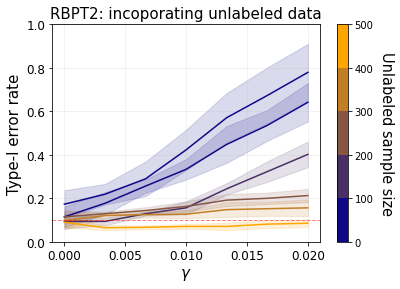

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a new colormap that starts with the first color of 'plasma' and ends with orange
colors = [plt.cm.plasma(0), "orange"]
n_bins = [3, 2]  # Discretizes the interpolation into bins
cmap_name = 'custom_plasma'
# Create the colormap
new_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=sum(n_bins))

# Use new colormap in your plot
cmap = new_cmap

# Normalize to [0,1]
norm = plt.Normalize(us[0],us[-1])

# Create the line plot
for i in range(num_rows):
    plt.plot(gammas, data_mean[i, :], color=cmap(norm(us[i])))
    plt.fill_between(gammas, data_mean[i, :]-data_std[i, :], data_mean[i, :]+data_std[i, :], color=cmap(norm(us[i])), alpha=.15)

# Adding a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Unlabeled sample size', rotation=270, labelpad=20, size=14.5)

plt.title("RBPT2: incoporating unlabeled data", size=15)
plt.xticks(fontsize=12)
plt.xlabel('$\gamma$', size=15)
plt.yticks(fontsize=12)
plt.ylabel('Type-I error rate', size=15)
plt.axhline(y=alpha, color='r', linestyle='--', lw=1, alpha=.5)
plt.grid(alpha=.2)
plt.ylim(0,1)
plt.savefig('plots/exp_review2.png', bbox_inches='tight', dpi=300, transparent=True)    
plt.show()
